In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# LOAD DATA
# ==========================
df = pd.read_csv("/Users/chariskee/Downloads/dataset_A_gdp_life.csv")
df.columns = df.columns.str.strip()
X = df[['GDP per capita USD']].values
y = df['Life Expectancy'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================
# EVALUATION FUNCTION
# ==========================
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    best_params = getattr(model, 'best_params_', 'N/A')
    print(f"\n{name}")
    if best_params != 'N/A':
        print(f"  Best params: {best_params}")
    print(f"  MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
    return {'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

results = []

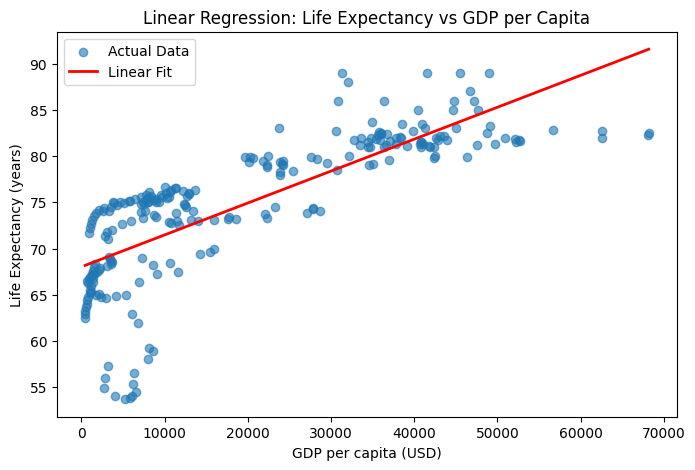


Linear Regression (log GDP)
  MAE: 2.891, MSE: 18.857, RMSE: 4.342, R²: 0.649


In [19]:
# ==========================
# 1. LINEAR REGRESSION (BASIC)
# ==========================
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(X, y, label='Actual Data', alpha=0.6)
xx = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
plt.plot(xx, lin_model.predict(xx), color='red', linewidth=2, label='Linear Fit')
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life Expectancy (years)')
plt.title('Linear Regression: Life Expectancy vs GDP per Capita')
plt.legend()
plt.show()

# ==========================
# 2. LOG-LINEAR REGRESSION
# ==========================
log_lin_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
log_lin_pipeline.fit(X_train, y_train)
results.append(evaluate_model("Linear Regression (log GDP)", log_lin_pipeline, X_test, y_test))

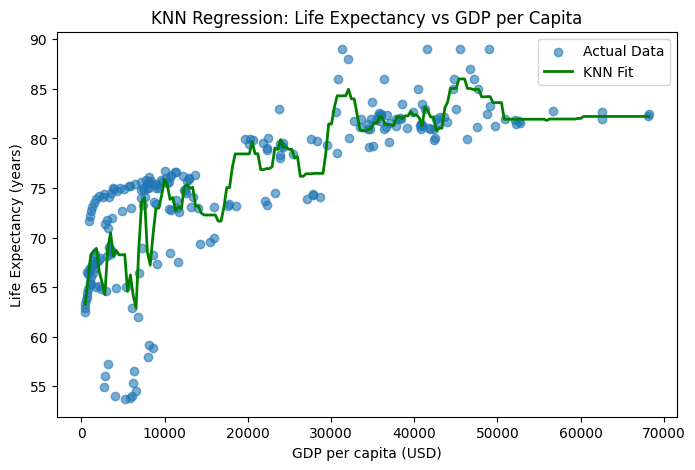


KNN Regression (tuned)
  Best params: {'model__n_neighbors': 9, 'model__weights': 'uniform'}
  MAE: 2.723, MSE: 13.989, RMSE: 3.740, R²: 0.739


In [20]:
# ==========================
# 3. KNN REGRESSION (BASIC)
# ==========================
knn_model = KNeighborsRegressor()  # default n_neighbors=5
knn_model.fit(X_train, y_train)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(X, y, label='Actual Data', alpha=0.6)
xx = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
plt.plot(xx, knn_model.predict(xx), color='green', linewidth=2, label='KNN Fit')
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life Expectancy (years)')
plt.title('KNN Regression: Life Expectancy vs GDP per Capita')
plt.legend()
plt.show()

# ==========================
# 4. KNN REGRESSION (TUNED)
# ==========================
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_knn.fit(X_train, y_train)
results.append(evaluate_model("KNN Regression (tuned)", grid_knn, X_test, y_test))

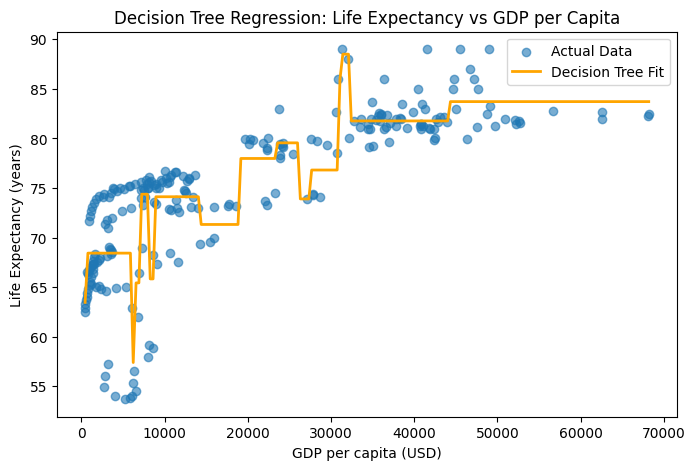


Decision Tree Regression (tuned)
  Best params: {'model__max_depth': 2, 'model__min_samples_leaf': 1}
  MAE: 2.460, MSE: 11.985, RMSE: 3.462, R²: 0.777


In [21]:
# ==========================
# 5. DECISION TREE REGRESSION (BASIC)
# ==========================
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(X, y, label='Actual Data', alpha=0.6)
xx = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
plt.plot(xx, tree_model.predict(xx), color='orange', linewidth=2, label='Decision Tree Fit')
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life Expectancy (years)')
plt.title('Decision Tree Regression: Life Expectancy vs GDP per Capita')
plt.legend()
plt.show()

# ==========================
# 6. DECISION TREE REGRESSION (TUNED)
# ==========================
tree_pipeline = Pipeline([
    ('model', DecisionTreeRegressor(random_state=42))
])
param_grid_tree = {
    'model__max_depth': [2, 4, 6, 8, 10],
    'model__min_samples_leaf': [1, 2, 4, 6]
}
grid_tree = GridSearchCV(tree_pipeline, param_grid_tree, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_tree.fit(X_train, y_train)
results.append(evaluate_model("Decision Tree Regression (tuned)", grid_tree, X_test, y_test))

In [22]:
# ==========================
# FINAL MODEL COMPARISON
# ==========================
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print("\n=== Model Comparison after tuning===")
print(results_df)


=== Model Comparison after tuning===
                              Model       MAE        MSE      RMSE        R2
2  Decision Tree Regression (tuned)  2.459515  11.984820  3.461910  0.776711
1            KNN Regression (tuned)  2.723380  13.989025  3.740191  0.739371
0       Linear Regression (log GDP)  2.890532  18.856866  4.342449  0.648678
